In [1]:
%matplotlib inline

import random
import math
import sys

from sklearn.neighbors import KDTree
from sklearn.metrics import mean_absolute_error
import pandas as pd
from pandas import Series, DataFrame
import numpy as np

sys.setrecursionlimit(10000) # KDTree will recurse and throw an error otherwise.

In [2]:
file_name = './data/king_county_data_geocoded.csv'
df = pd.read_csv(file_name)
df.describe()

,AppraisedValue,SqFtLot,WaterSystem,SewerSystem,Access,Topography,StreetSurface,RestrictiveSzShape,InadequateParking,PcntUnusable,...,NativeGrowthProtEsmt,Easements,OtherDesignation,DeedRestrictions,DevelopmentRightsPurch,WaterProblems,TranspConcurrency,OtherProblems,lat,long
count,52420.000000,5.242000e+04,52420.000000,52420.000000,52420.000000,52420.000000,52420.000000,52420.000000,52420.000000,52420.000000,...,52420.000000,52420.000000,52420.000000,52420.000000,52420.000000,52420.000000,52420.000000,52420.000000,52420.000000,52420.000000
mean,407117.694868,1.961896e+04,1.962228,1.836436,3.935311,0.072282,1.022453,0.003815,1.079760,0.012572,...,0.002423,0.017360,0.000343,0.001755,0.000362,0.009500,0.000134,0.003491,47.442801,-121.828803
std,185186.952252,8.285164e+04,0.193526,0.372811,0.276779,0.258956,0.191910,0.061651,0.996546,0.865810,...,0.049162,0.130609,0.018528,0.041857,0.019035,0.097006,0.011555,0.058982,1.199939,3.731911
min,10300.000000,5.050000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,25.554840,-149.881942
25%,263000.000000,5.570750e+03,2.000000,2.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.434030,-122.328562
50%,370000.000000,7.920000e+03,2.000000,2.000000,4.000000,0.000000,1.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.556457,-122.245136
75%,513000.000000,1.116525e+04,2.000000,2.000000,4.000000,0.000000,1.000000,0.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,47.676197,-122.134176
max,999000.000000,7.039596e+06,4.000000,3.000000,5.000000,1.000000,4.000000,1.000000,2.000000,100.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,64.832940,13.441879


In [3]:
df.head()

,AppraisedValue,SqFtLot,WaterSystem,SewerSystem,Access,Topography,StreetSurface,RestrictiveSzShape,InadequateParking,PcntUnusable,...,NativeGrowthProtEsmt,Easements,OtherDesignation,DeedRestrictions,DevelopmentRightsPurch,WaterProblems,TranspConcurrency,OtherProblems,lat,long
0,619000.0,6542712,1,1,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,47.354019,-122.225166
1,708000.0,105850,2,1,3,0,2,0,0,0,...,0,0,0,0,0,0,0,0,47.611248,-122.053154
2,297000.0,1667,2,2,4,0,1,0,2,0,...,0,0,0,0,0,0,0,0,47.701248,-122.365784
3,523000.0,1872,2,2,4,0,1,0,2,0,...,0,0,0,0,0,0,0,0,47.537918,-122.392845
4,288000.0,3480,2,2,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,47.510227,-122.182167


In [4]:
# Take the following rows at the given index.
df.iloc[[0, 1, 2]]

,AppraisedValue,SqFtLot,WaterSystem,SewerSystem,Access,Topography,StreetSurface,RestrictiveSzShape,InadequateParking,PcntUnusable,...,NativeGrowthProtEsmt,Easements,OtherDesignation,DeedRestrictions,DevelopmentRightsPurch,WaterProblems,TranspConcurrency,OtherProblems,lat,long
0,619000.0,6542712,1,1,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,47.354019,-122.225166
1,708000.0,105850,2,1,3,0,2,0,0,0,...,0,0,0,0,0,0,0,0,47.611248,-122.053154
2,297000.0,1667,2,2,4,0,1,0,2,0,...,0,0,0,0,0,0,0,0,47.701248,-122.365784


In [5]:
# Take 3 random samples from the range.
random.sample(range(10), 3)

[1, 8, 7]

In [6]:
df.sample(5).index, df.sample(5).index.tolist() # Get the indexes of random samples.

(Int64Index([21006, 24720, 16418, 21849, 8738], dtype='int64'),
 [21460, 39519, 50710, 38155, 47972])

In [7]:
df.index.tolist()[:5]

[0, 1, 2, 3, 4]

In [8]:
df2 = df.drop([0,1,2]) # Drop the first three rows.
df2.head()

,AppraisedValue,SqFtLot,WaterSystem,SewerSystem,Access,Topography,StreetSurface,RestrictiveSzShape,InadequateParking,PcntUnusable,...,NativeGrowthProtEsmt,Easements,OtherDesignation,DeedRestrictions,DevelopmentRightsPurch,WaterProblems,TranspConcurrency,OtherProblems,lat,long
3,523000.0,1872,2,2,4,0,1,0,2,0,...,0,0,0,0,0,0,0,0,47.537918,-122.392845
4,288000.0,3480,2,2,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,47.510227,-122.182167
5,319000.0,546348,2,1,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,47.354980,-122.231277
6,523000.0,7221,2,2,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,47.699162,-122.280426
7,482000.0,12008,2,2,3,0,2,0,2,0,...,0,0,0,0,0,0,0,0,47.699230,-122.201538


In [9]:
len(df)

52420

In [10]:
latlng = df[['lat', 'long']]
latlng.head()

,lat,long
0,47.354019,-122.225166
1,47.611248,-122.053154
2,47.701248,-122.365784
3,47.537918,-122.392845
4,47.510227,-122.182167


In [11]:
tree = KDTree(latlng)
distances, indexes = tree.query([latlng.iloc[0].tolist()], k = 3)
distances, indexes

(array([[0.        , 0.00500314, 0.00618288]]), array([[   0, 3918, 6783]]))

In [12]:
math.floor(10.3)

10

In [13]:
values = df['AppraisedValue']
values[0] # Get a single value.

619000.0

In [14]:
values[[0,1,2]] # Get multiple values.

0    619000.0
1    708000.0
2    297000.0
Name: AppraisedValue, dtype: float64

In [72]:
class Regression:
    def __init__(self, csv_file=None, data=None, values=None):
        if (data is None and csv_file is not None):
            df = pd.read_csv(csv_file)
            # The target values.
            self.values = df['AppraisedValue']
            
            # Remove the target values from the DataFrame.
            df = df.drop('AppraisedValue', 1)
            
            # Scale the feature values.
            df = (df - df.mean()) / (df.max() - df.min())
            self.df = df 
            self.df = self.df[['lat', 'long', 'SqFtLot']]
        elif (data is not None and values is not None):
            self.df = data
            self.values = values
        else:
            raise ValueError('Must have either csv_file or data set')
    
        self.n = len(self.df)
        self.kdtree = KDTree(self.df)
        self.metric = np.mean
        self.k = 5
    
    def regress(self, query_point):
        distances, indexes = self.kdtree.query(query_point, self.k)
        m = self.metric(self.values.iloc[indexes.tolist()[0]])
        if np.isnan(m):
            zomg
        else:
            return m
        
    def error_rate(self, folds):
        holdout = 1 / float(folds)
        errors = []
        for fold in range(folds):
            print(f'fold {fold}/{folds} started')
            y_hat, y_true = self.__validation_data(holdout)
            errors.append(mean_absolute_error(y_true, y_hat))
            print(f'fold {fold}/{folds} completed')
        return errors

    def __validation_data(self, holdout):
        sample_size = int(math.floor(len(self.df) * holdout))
        test_rows = df.sample(sample_size).index.tolist()
        train_rows = list(set(self.df.index.tolist()) - set(test_rows))

        df_test = self.df.iloc[test_rows]
        df_train = self.df.drop(test_rows)
        test_values = self.values.iloc[test_rows]
        train_values = self.values.iloc[train_rows]
        kd = Regression(data=df_train, values=train_values)
        
        y_hat = []
        y_actual = []
        i, n = 0, len(df_test)
        
        for idx, row in df_test.iterrows():
            y_hat.append(kd.regress([row.tolist()]))
            y_actual.append(self.values[idx])
            i += 1
            if i % 1000 == 0: print(f'{i/n * 100:.2f}%')
        return (y_hat, y_actual)
    
    def plot_error_rates(self):
        folds = range(2, 11)
        errors = pd.DataFrame({'max': 0, 'min': 0}, index=folds)
        for f in folds:
            print(f'plot_error_rates started: {f}')
            error_rates = self.error_rate(f)
            errors['max'][f] = max(error_rates)
            errors['min'][f] = min(error_rates)
            print(f'plot_error_rates ended: {f}')
        errors.plot(title='Mean Absolute Error of KNN over different folds')

In [73]:
regression = Regression(file_name)
regression.values.head()

0    619000.0
1    708000.0
2    297000.0
3    523000.0
4    288000.0
Name: AppraisedValue, dtype: float64

In [74]:
point = regression.df.iloc[0]
point

lat       -0.002260
long      -0.002427
SqFtLot    0.926695
Name: 0, dtype: float64

In [75]:
distances, indexes = regression.kdtree.query([point], regression.k)
indexes, [idx for idx in indexes]

(array([[    0, 46726, 46679, 47091, 47026]]),
 [array([    0, 46726, 46679, 47091, 47026])])

In [76]:
regression.values.iloc[indexes.tolist()[0]]

0        619000.0
46726    657000.0
46679    962000.0
47091    796000.0
47026    635000.0
Name: AppraisedValue, dtype: float64

plot_error_rates started: 2
fold 0/2 started
0.38153376573826786%
0.7630675314765357%
1.1446012972148036%
1.5261350629530714%
1.907668828691339%
2.2892025944296073%
2.670736360167875%
3.052270125906143%
3.43380389164441%
3.815337657382678%
4.196871423120947%
4.5784051888592145%
4.959938954597482%
5.34147272033575%
5.723006486074018%
6.104540251812286%
6.4860740175505525%
6.86760778328882%
7.2491415490270885%
7.630675314765356%
8.012209080503624%
8.393742846241894%
8.77527661198016%
9.156810377718429%
9.538344143456696%
9.919877909194964%
10.301411674933233%
10.6829454406715%
11.064479206409768%
11.446012972148036%
11.827546737886303%
12.209080503624572%
12.590614269362838%
12.972148035101105%
13.353681800839373%
13.73521556657764%
14.116749332315909%
14.498283098054177%
14.879816863792444%
15.261350629530712%
15.64288439526898%
16.024418161007247%
16.405951926745516%
16.787485692483788%
17.169019458222053%
17.55055322396032%
17.93208698969859%
18.313620755436858%
18.695154521175127%
19

61.808470049599386%
62.19000381533766%
62.57153758107592%
62.95307134681419%
63.33460511255245%
63.71613887829073%
64.09767264402899%
64.47920640976726%
64.86074017550553%
65.2422739412438%
65.62380770698206%
66.00534147272033%
66.3868752384586%
66.76840900419687%
67.14994276993515%
67.5314765356734%
67.91301030141167%
68.29454406714994%
68.67607783288821%
69.05761159862648%
69.43914536436475%
69.82067913010302%
70.20221289584128%
70.58374666157955%
70.96528042731782%
71.34681419305609%
71.72834795879436%
72.10988172453263%
72.4914154902709%
72.87294925600915%
73.25448302174743%
73.63601678748569%
74.01755055322397%
74.39908431896222%
74.7806180847005%
75.16215185043876%
75.54368561617704%
75.9252193819153%
76.30675314765357%
76.68828691339183%
77.0698206791301%
77.45135444486837%
77.83288821060664%
78.21442197634491%
78.59595574208318%
78.97748950782145%
79.35902327355971%
79.74055703929798%
80.12209080503625%
80.50362457077452%
80.88515833651279%
81.26669210225104%
81.64822586798932%

85.8467349625136%
86.41904652893035%
86.99135809534711%
87.56366966176387%
88.13598122818063%
88.70829279459738%
89.28060436101414%
89.8529159274309%
90.42522749384764%
90.99753906026442%
91.56985062668117%
92.14216219309792%
92.71447375951468%
93.28678532593143%
93.85909689234819%
94.43140845876495%
95.0037200251817%
95.57603159159846%
96.14834315801522%
96.72065472443198%
97.29296629084874%
97.8652778572655%
98.43758942368225%
99.00990099009901%
99.58221255651577%
fold 1/3 completed
fold 2/3 started
0.5723115664167573%
1.1446231328335146%
1.7169346992502716%
2.289246265667029%
2.8615578320837867%
3.4338693985005433%
4.006180964917301%
4.578492531334058%
5.150804097750815%
5.723115664167573%
6.29542723058433%
6.867738797001087%
7.440050363417845%
8.012361929834602%
8.584673496251359%
9.156985062668117%
9.729296629084875%
10.30160819550163%
10.873919761918389%
11.446231328335147%
12.018542894751903%
12.59085446116866%
13.163166027585419%
13.735477594002173%
14.307789160418933%
14.88010

68.67607783288821%
69.43914536436475%
70.20221289584128%
70.96528042731782%
71.72834795879436%
72.4914154902709%
73.25448302174743%
74.01755055322397%
74.7806180847005%
75.54368561617704%
76.30675314765357%
77.0698206791301%
77.83288821060664%
78.59595574208318%
79.35902327355971%
80.12209080503625%
80.88515833651279%
81.64822586798932%
82.41129339946586%
83.1743609309424%
83.93742846241892%
84.70049599389546%
85.463563525372%
86.22663105684853%
86.98969858832507%
87.7527661198016%
88.51583365127814%
89.27890118275468%
90.04196871423122%
90.80503624570775%
91.56810377718429%
92.33117130866081%
93.09423884013735%
93.85730637161389%
94.62037390309042%
95.38344143456696%
96.1465089660435%
96.90957649752004%
97.67264402899657%
98.43571156047311%
99.19877909194965%
99.96184662342617%
fold 1/4 completed
fold 2/4 started
0.7630675314765357%
1.5261350629530714%
2.2892025944296073%
3.052270125906143%
3.815337657382678%
4.5784051888592145%
5.34147272033575%
6.104540251812286%
6.86760778328882%
7

10.492178557802365%
11.446012972148036%
12.399847386493706%
13.353681800839373%
14.307516215185043%
15.261350629530712%
16.21518504387638%
17.169019458222053%
18.122853872567724%
19.07668828691339%
20.030522701259063%
20.98435711560473%
21.9381915299504%
22.892025944296073%
23.84586035864174%
24.79969477298741%
25.75352918733308%
26.707363601678747%
27.661198016024418%
28.615032430370086%
29.568866844715757%
30.522701259061424%
31.476535673407096%
32.43037008775276%
33.384204502098434%
34.338038916444106%
35.29187333078978%
36.24570774513545%
37.19954215948111%
38.15337657382678%
39.107210988172454%
40.061045402518126%
41.01487981686379%
41.96871423120946%
42.92254864555513%
43.8763830599008%
44.83021747424647%
45.784051888592145%
46.73788630293781%
47.69172071728348%
48.645555131629145%
49.59938954597482%
50.553223960320494%
51.50705837466616%
52.46089278901182%
53.414727203357494%
54.36856161770317%
55.322396032048836%
56.27623044639451%
57.23006486074017%
58.18389927508585%
59.13773

14.880952380952381%
16.025641025641026%
17.17032967032967%
18.315018315018314%
19.45970695970696%
20.604395604395602%
21.749084249084248%
22.893772893772894%
24.03846153846154%
25.183150183150182%
26.32783882783883%
27.472527472527474%
28.617216117216117%
29.761904761904763%
30.90659340659341%
32.05128205128205%
33.19597069597069%
34.34065934065934%
35.485347985347985%
36.63003663003663%
37.77472527472527%
38.91941391941392%
40.06410256410257%
41.208791208791204%
42.353479853479854%
43.498168498168496%
44.642857142857146%
45.78754578754579%
46.93223443223443%
48.07692307692308%
49.22161172161172%
50.366300366300365%
51.51098901098901%
52.65567765567766%
53.8003663003663%
54.94505494505495%
56.08974358974359%
57.234432234432234%
58.37912087912088%
59.523809523809526%
60.66849816849816%
61.81318681318682%
62.95787545787546%
64.1025641025641%
65.24725274725274%
66.39194139194139%
67.53663003663004%
68.68131868131869%
69.82600732600733%
70.97069597069597%
72.11538461538461%
73.260073260073

97.2985347985348%
98.44322344322345%
99.58791208791209%
fold 4/6 completed
fold 5/6 started
1.1446886446886446%
2.2893772893772892%
3.4340659340659343%
4.5787545787545785%
5.7234432234432235%
6.868131868131869%
8.012820512820513%
9.157509157509157%
10.302197802197801%
11.446886446886447%
12.591575091575091%
13.736263736263737%
14.880952380952381%
16.025641025641026%
17.17032967032967%
18.315018315018314%
19.45970695970696%
20.604395604395602%
21.749084249084248%
22.893772893772894%
24.03846153846154%
25.183150183150182%
26.32783882783883%
27.472527472527474%
28.617216117216117%
29.761904761904763%
30.90659340659341%
32.05128205128205%
33.19597069597069%
34.34065934065934%
35.485347985347985%
36.63003663003663%
37.77472527472527%
38.91941391941392%
40.06410256410257%
41.208791208791204%
42.353479853479854%
43.498168498168496%
44.642857142857146%
45.78754578754579%
46.93223443223443%
48.07692307692308%
49.22161172161172%
50.366300366300365%
51.51098901098901%
52.65567765567766%
53.800366

40.06410256410257%
41.39957264957265%
42.73504273504273%
44.07051282051282%
45.4059829059829%
46.741452991452995%
48.07692307692308%
49.412393162393165%
50.74786324786324%
52.083333333333336%
53.41880341880342%
54.75427350427351%
56.08974358974359%
57.42521367521367%
58.76068376068376%
60.09615384615385%
61.43162393162393%
62.76709401709402%
64.1025641025641%
65.4380341880342%
66.77350427350427%
68.10897435897436%
69.44444444444444%
70.77991452991454%
72.11538461538461%
73.4508547008547%
74.78632478632478%
76.12179487179486%
77.45726495726495%
78.79273504273505%
80.12820512820514%
81.46367521367522%
82.7991452991453%
84.13461538461539%
85.47008547008546%
86.80555555555556%
88.14102564102564%
89.47649572649573%
90.8119658119658%
92.1474358974359%
93.48290598290599%
94.81837606837607%
96.15384615384616%
97.48931623931624%
98.82478632478633%
fold 4/7 completed
fold 5/7 started
1.3354700854700854%
2.6709401709401708%
4.006410256410256%
5.3418803418803416%
6.677350427350428%
8.0128205128205

42.73504273504273%
44.26129426129426%
45.78754578754579%
47.31379731379731%
48.84004884004884%
50.366300366300365%
51.8925518925519%
53.41880341880342%
54.94505494505495%
56.47130647130647%
57.997557997558005%
59.523809523809526%
61.05006105006105%
62.576312576312574%
64.1025641025641%
65.62881562881563%
67.15506715506714%
68.68131868131869%
70.2075702075702%
71.73382173382173%
73.26007326007326%
74.78632478632478%
76.31257631257631%
77.83882783882784%
79.36507936507937%
80.8913308913309%
82.41758241758241%
83.94383394383395%
85.47008547008546%
86.99633699633699%
88.52258852258852%
90.04884004884005%
91.57509157509158%
93.1013431013431%
94.62759462759462%
96.15384615384616%
97.68009768009767%
99.20634920634922%
fold 3/8 completed
fold 4/8 started
1.5262515262515262%
3.0525030525030523%
4.5787545787545785%
6.105006105006105%
7.631257631257632%
9.157509157509157%
10.683760683760683%
12.21001221001221%
13.736263736263737%
15.262515262515263%
16.788766788766786%
18.315018315018314%
19.8412

3.4340659340659343%
5.151098901098901%
6.868131868131869%
8.585164835164836%
10.302197802197801%
12.01923076923077%
13.736263736263737%
15.453296703296704%
17.17032967032967%
18.887362637362635%
20.604395604395602%
22.321428571428573%
24.03846153846154%
25.755494505494504%
27.472527472527474%
29.18956043956044%
30.90659340659341%
32.62362637362637%
34.34065934065934%
36.05769230769231%
37.77472527472527%
39.49175824175824%
41.208791208791204%
42.925824175824175%
44.642857142857146%
46.35989010989011%
48.07692307692308%
49.793956043956044%
51.51098901098901%
53.22802197802198%
54.94505494505495%
56.66208791208791%
58.37912087912088%
60.09615384615385%
61.81318681318682%
63.530219780219774%
65.24725274725274%
66.96428571428571%
68.68131868131869%
70.39835164835165%
72.11538461538461%
73.83241758241759%
75.54945054945054%
77.26648351648352%
78.98351648351648%
80.70054945054946%
82.41758241758241%
84.13461538461539%
85.85164835164835%
87.56868131868131%
89.28571428571429%
91.00274725274726

13.353681800839373%
15.261350629530712%
17.169019458222053%
19.07668828691339%
20.98435711560473%
22.892025944296073%
24.79969477298741%
26.707363601678747%
28.615032430370086%
30.522701259061424%
32.43037008775276%
34.338038916444106%
36.24570774513545%
38.15337657382678%
40.061045402518126%
41.96871423120946%
43.8763830599008%
45.784051888592145%
47.69172071728348%
49.59938954597482%
51.50705837466616%
53.414727203357494%
55.322396032048836%
57.23006486074017%
59.13773368943151%
61.04540251812285%
62.95307134681419%
64.86074017550553%
66.76840900419687%
68.67607783288821%
70.58374666157955%
72.4914154902709%
74.39908431896222%
76.30675314765357%
78.21442197634491%
80.12209080503625%
82.02975963372758%
83.93742846241892%
85.84509729111026%
87.7527661198016%
89.66043494849293%
91.56810377718429%
93.47577260587562%
95.38344143456696%
97.29111026325829%
99.19877909194965%
fold 0/10 completed
fold 1/10 started
1.907668828691339%
3.815337657382678%
5.723006486074018%
7.630675314765356%
9.5

7.630675314765356%
9.538344143456696%
11.446012972148036%
13.353681800839373%
15.261350629530712%
17.169019458222053%
19.07668828691339%
20.98435711560473%
22.892025944296073%
24.79969477298741%
26.707363601678747%
28.615032430370086%
30.522701259061424%
32.43037008775276%
34.338038916444106%
36.24570774513545%
38.15337657382678%
40.061045402518126%
41.96871423120946%
43.8763830599008%
45.784051888592145%
47.69172071728348%
49.59938954597482%
51.50705837466616%
53.414727203357494%
55.322396032048836%
57.23006486074017%
59.13773368943151%
61.04540251812285%
62.95307134681419%
64.86074017550553%
66.76840900419687%
68.67607783288821%
70.58374666157955%
72.4914154902709%
74.39908431896222%
76.30675314765357%
78.21442197634491%
80.12209080503625%
82.02975963372758%
83.93742846241892%
85.84509729111026%
87.7527661198016%
89.66043494849293%
91.56810377718429%
93.47577260587562%
95.38344143456696%
97.29111026325829%
99.19877909194965%
fold 8/10 completed
fold 9/10 started
1.907668828691339%
3.

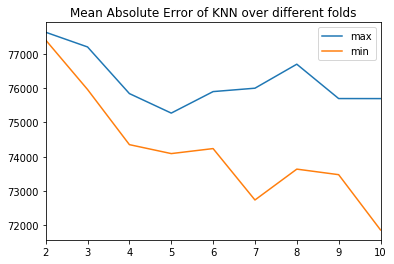

In [77]:
regression.plot_error_rates()